In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from seaborn import load_dataset
from fastprogress import master_bar, progress_bar
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Generate Synthetic Dataset

In [2]:
x0 = np.random.multivariate_normal([-1.5,0], [[1,0],[0,1]], 100)
x1 = np.random.multivariate_normal([1.5,0], [[1,0],[0,1]], 100)

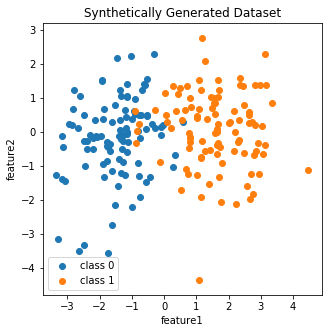

In [3]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x0[:,0],x0[:,1], label='class 0')
ax.scatter(x1[:,0],x1[:,1], label='class 1')
ax.legend()
ax.set_title('Synthetically Generated Dataset')
ax.set_xlabel('feature1'); ax.set_ylabel('feature2')
plt.show()

In [4]:
X = pd.DataFrame(np.concatenate([x0,x1]), columns=['feature1','feature2'])
y = np.array([0]*100 + [1]*100)

In [5]:
X.shape, y.shape
# ((200, 2), (200,))

((200, 2), (200,))

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=50, random_state=199)

# Pytorch Data and Model

In [7]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).type(torch.FloatTensor)
        self.y = torch.from_numpy(y).type(torch.FloatTensor).reshape(-1,1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [8]:
# instantiate datasets and dataloaders for train and valid data
train_ds = SimpleDataset(X_train, y_train)
valid_ds = SimpleDataset(X_valid, y_valid)
train_dl = DataLoader(train_ds, batch_size=150)
valid_dl = DataLoader(valid_ds, batch_size=50)

In [9]:
class LogisticRegression(nn.Module):
    def __init__(self, p):
        super().__init__()
        # single linear layer. non-linearity is handled
        # by the loss function
        self.lin = nn.Linear(p, 1)
    
    def forward(self, x):
        x = self.lin(x)
        return x

# Train Model

In [10]:
model = LogisticRegression(train_ds.X.shape[1])

In [11]:
num_epochs = 100
lr = 3e-2
optim = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()
final_actn = torch.nn.Sigmoid()

In [12]:
model.train()
train_losses = []
valid_losses = []
mb = master_bar(range(num_epochs))
for _ in mb:
    pb = progress_bar(train_dl, parent=mb)
    train_batch_losses = []
    for X, y in pb:
        optim.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        train_batch_losses.append(loss.item())
    train_losses.append(np.array(train_batch_losses).mean())
    
    model.eval()
    valid_batch_losses = []
    for X_val, y_val in valid_dl:
        out = model(X_val)
        val_loss = criterion(out, y_val).item()
        valid_batch_losses.append(val_loss)
    valid_losses.append(np.array(valid_batch_losses).mean())

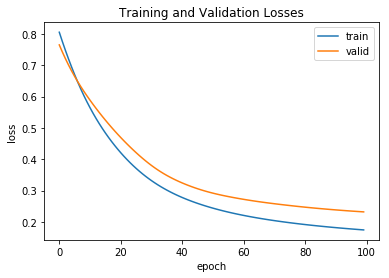

In [13]:
fig, ax = plt.subplots()
x = range(len(train_losses))
ax.plot(x, train_losses, label='train')
ax.plot(x, valid_losses, label='valid')
ax.set_title('Training and Validation Losses')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
plt.show()

# Calculate AUC using Scikit-Learn Function

In [14]:
valid_scores = []
model.eval()
for X_val, y_val in valid_dl:
    out = model(X_val)
    out = out.reshape(-1).tolist()
    valid_scores.extend(out)

In [15]:
valid_scores = torch.Tensor(valid_scores)
valid_scores

tensor([ 1.3256, -3.9111,  0.9515,  3.7141, -3.9993, -3.3840, -1.6937, -1.7872,
         5.4634, -2.6962,  0.3090, -3.8332,  2.0432, -0.4319, -1.3281, -1.3519,
         1.3732,  2.6428,  0.5165, -0.6518,  1.5274,  4.4482, -1.7946, -1.2051,
        -0.7633,  2.7398, -2.3134,  2.7641,  4.1584, -0.0191, -2.0982,  2.8374,
        -1.0771, -2.8697,  2.5235, -2.8222,  4.1701, -0.9285,  4.1537, -2.7113,
         2.5709, -3.7759,  3.6061,  1.5652, -1.8460,  1.0918, -0.2882,  3.0891,
         5.1594, -2.1279])

In [16]:
valid_probas = final_actn(valid_scores)
valid_probas

tensor([0.7901, 0.0196, 0.7214, 0.9762, 0.0180, 0.0328, 0.1553, 0.1434, 0.9958,
        0.0632, 0.5766, 0.0212, 0.8853, 0.3937, 0.2095, 0.2056, 0.7979, 0.9336,
        0.6263, 0.3426, 0.8216, 0.9884, 0.1425, 0.2306, 0.3179, 0.9393, 0.0900,
        0.9407, 0.9846, 0.4952, 0.1093, 0.9447, 0.2541, 0.0537, 0.9258, 0.0561,
        0.9848, 0.2832, 0.9845, 0.0623, 0.9290, 0.0224, 0.9736, 0.8271, 0.1363,
        0.7487, 0.4284, 0.9564, 0.9943, 0.1064])

In [17]:
valid_scores = valid_scores.numpy()
valid_probas = valid_probas.numpy()

In [18]:
roc_auc_score(y_valid, valid_probas)

0.9759615384615384

In [19]:
roc_auc_score(y_valid, valid_scores)

0.9759615384615384

# Manually Construct ROC Curve and AUC Calculation

Toss the model probabilities and true values into a dataframe.

In [20]:
auc_data = pd.DataFrame({'probas':valid_probas, 'y_true':y_valid})
auc_data.head()

,probas,y_true
0,0.790115,1
1,0.019625,0
2,0.721424,1
3,0.976202,1
4,0.017999,0


Sort the data by the model probabilities.

In [21]:
auc_data.sort_values(by='probas', ascending=False, inplace=True)
auc_data = auc_data.reset_index(drop=True)
auc_data.head()

,probas,y_true
0,0.995779,1
1,0.994287,1
2,0.988435,1
3,0.984784,1
4,0.984608,1


Create a simple "rank" column.

In [22]:
auc_data['rank'] = range(1,len(auc_data)+1)
auc_data.head()

,probas,y_true,rank
0,0.995779,1,1
1,0.994287,1,2
2,0.988435,1,3
3,0.984784,1,4
4,0.984608,1,5


Delete the model probabilities data in order to illustrate the point that they aren't needed for ROC or AUC calculations (after they've been used to rank order).

In [23]:
auc_data.drop(columns=['probas'], inplace=True)
auc_data.head()

,y_true,rank
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5


Precompute a cumulative sum of the true values. This will come in handy later when we're performing the calculations.

In [24]:
auc_data['y_true_cumsum'] = auc_data['y_true'].cumsum()
auc_data.head()

,y_true,rank,y_true_cumsum
0,1,1,1
1,1,2,2
2,1,3,3
3,1,4,4
4,1,5,5


ROC Curve Plots TPR vs FPR

- True Positive Rate (TPR), Recall, "Probability of Detection"
- False Positive Rate (FPR), "Probability of False Alarm"

Precompute the number of data points in the positive and negative classes.

In [25]:
n_pos = (auc_data['y_true']==1).sum()
n_neg = (auc_data['y_true']==0).sum()

In [26]:
tpr = [0]; fpr = [0]; area = []

# iterate over data points, ie, **thresholds**
for _,row in auc_data.iterrows():
    
    # the "rank" column conveniently proxies for the number of
    # data points being predicted as the positive class
    num_pred_p = row['rank']
    
    # the cumulative sum of y_true equals the the number of
    # true positives at this threshold
    num_tp = row['y_true_cumsum']
    
    # the number of false positives is then the difference
    # between the total number of predicted positives 
    # and the number of true positives
    num_fp = num_pred_p - num_tp
    
    # compute TPR and FPR at this threshold and store it
    tpr_tmp = num_tp / n_pos
    fpr_tmp = num_fp / n_neg
    tpr.append(tpr_tmp); fpr.append(fpr_tmp)
    
    # compute the area of the little rectangle at this threshold
    delta_fpr = (fpr[-1] - fpr[-2])
    area_tmp = tpr[-1] * delta_fpr
    area.append(area_tmp)

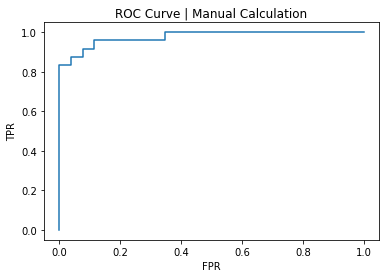

In [28]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('ROC Curve | Manual Calculation')
ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
plt.show()

AUC, manual calculation

In [32]:
np.array(area).sum()

0.9759615384615383

Scikit-learn ROC calculations

In [30]:
fpr_skl, tpr_skl, _ = roc_curve(y_valid, valid_probas)

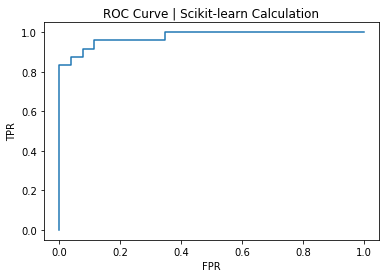

In [31]:
fig, ax = plt.subplots()
ax.plot(fpr_skl, tpr_skl)
ax.set_title('ROC Curve | Scikit-learn Calculation')
ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
plt.show()

AUC, scikit-learn calculation

In [33]:
auc(fpr_skl, tpr_skl)

0.9759615384615384